In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [34]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Probabilistic Modeling Overview:

We use a combination of BG/NBD and Gamma-Gamma models to estimate Customer Lifetime Value (CLV).

- BG/NBD (Beta Geometric/Negative Binomial Distribution):
   - Predicts the expected number of future transactions
   - Estimates the probability a customer is still 'alive' (active)
- Gamma-Gamma Model:
    - Predicts the expected average monetary value of each transaction

CLV Formula:
     CLV = (Expected Transactions) × (Expected Monetary Value) × (Business-defined Margin)

Margin may depend on discounts, campaign costs, or price-related business strategies.

In [35]:
df = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Preprocessing

In [36]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [37]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Data Cleaning

- customerID: remove missing values, because the model is built on specific customers.
- Quantity: remove negative records (the data is based on accounting records, positive records have related negative records)

In [38]:
dfnew = df[(df.Quantity>0) & (df.CustomerID.isnull() == False)]

dfnew['amt'] = dfnew['Quantity'] * dfnew['UnitPrice']
dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate']).dt.date

# EDA

- 4339 customers
- 397,924 transactions
- Date: 2010-12-01 to 2011-12-09
- Average CLV: 2053.79, median CLV: 674.45

In [12]:
print(dfnew['InvoiceDate'].min())
print(dfnew['InvoiceDate'].max())

2010-12-01
2011-12-09


In [14]:
#number of customers
dfnew['CustomerID'].nunique()

4339

In [28]:
cust = dfnew.groupby(['CustomerID']).agg({
    'InvoiceNo': 'count',
    'amt': 'sum'
}).reset_index()

In [29]:
cust.describe()

,CustomerID,InvoiceNo,amt
count,4339.000000,4339.000000,4339.000000
mean,15299.936852,91.708689,2053.793018
std,1721.889758,228.792852,8988.248381
min,12346.000000,1.000000,0.000000
25%,13812.500000,17.000000,307.245000
50%,15299.000000,41.000000,674.450000
75%,16778.500000,100.000000,1661.640000
max,18287.000000,7847.000000,280206.020000


# Feature Aggregation

The lifetime package is based on transaction data only. For each customer, aggregate:

- recency: days between first and last purchase in the given period.
- frequency: number of repeated purchase in the given period. More precisely, it's the count of days the customer made a repeated purchase.
- T: customer age, days since first purchase.
- monetary_value: transaction value in the given period.

In [17]:
from lifetimes.plotting import *
from lifetimes.utils import *

modeldata = summary_data_from_transaction_data(dfnew, 'CustomerID', 'InvoiceDate', 
                                               monetary_value_col='amt', 
                                               observation_period_end='2011-12-9')
modeldata.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


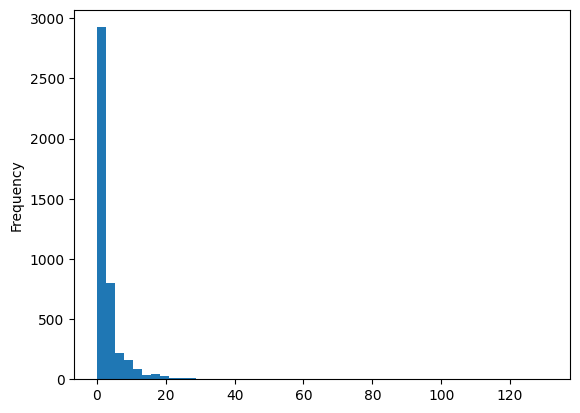

In [18]:
modeldata['frequency'].plot(kind='hist', bins=50)
print(modeldata['frequency'].describe())
#frequency=0 means no repeated purchase. 
#35.7% customers left after one purchase.
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

# BG/NBD Model  
*Beta-Geometric/Negative Binomial Distribution Model*

---

### Assumptions

1. **When a user is active**, the number of his transactions in a time period *t* is described by a **Poisson distribution** with transaction rate λ.  
<center><img src="Image#1.png" width="400"/></center>

2. **Transaction rate λ** has a **Gamma distribution** with parameters *r* (shape) and *α* (scale).  
<center><img src="Image#2.png" width="400"/></center>

3. **Users may become inactive** after any transaction with probability *p*, and their dropout point is distributed between purchases with a **Geometric distribution**.  
<center><img src="Image#3.png" width="400"/></center>

4. **Dropout probability *p*** has a **Beta distribution** with the two shape parameters *α* and *β*.  
<center><img src="Image#4.png" width="400"/></center>


In [23]:
from lifetimes import BetaGeoFitter

# penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


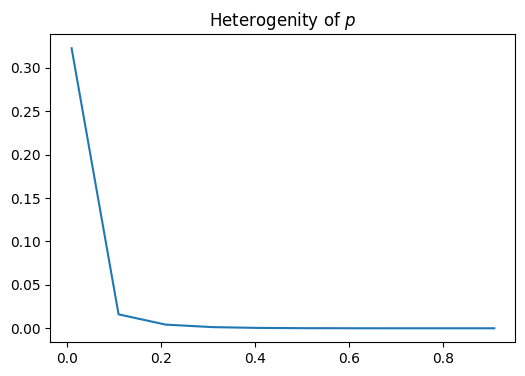

mean:  0.0005098191369753622
median:  3.2679898976484774e-89
std:  0.008107144032148269


In [24]:
from scipy.stats import gamma, beta

x = np.arange (0.01, 1, 0.1)
a, b = bgf.params_['a'], bgf.params_['b']
gbd = beta.pdf(x, a, b)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $p$')
temp = plt.plot(x, gbd)
plt.show()
print('mean: ', beta.mean(a, b))
print('median: ', beta.median(a, b))
print('std: ', beta.std(a, b))

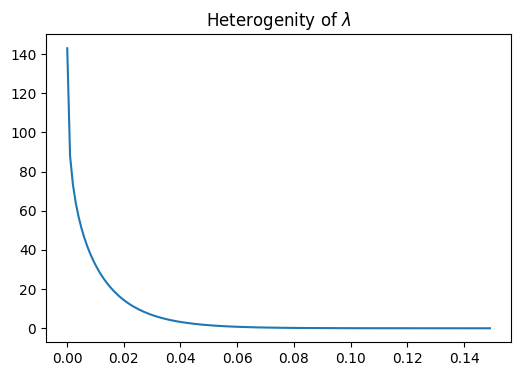

mean:  0.011996297994188745
median:  0.007641762756346371
std:  0.013196033019189141


In [25]:
x = np.arange (0.0001, 0.15, 0.001)
r, alpha = bgf.params_['r'], bgf.params_['alpha']
ggd = gamma.pdf(x, r, scale=1.0/alpha)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $\lambda$')
temp = plt.plot(x, ggd)
plt.show()
print('mean: ', gamma.mean(r, scale=1.0/alpha))
print('median: ', gamma.median(r, scale=1.0/alpha))
print('std: ', gamma.std(r, scale=1.0/alpha))

In [26]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


# Frequency-Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

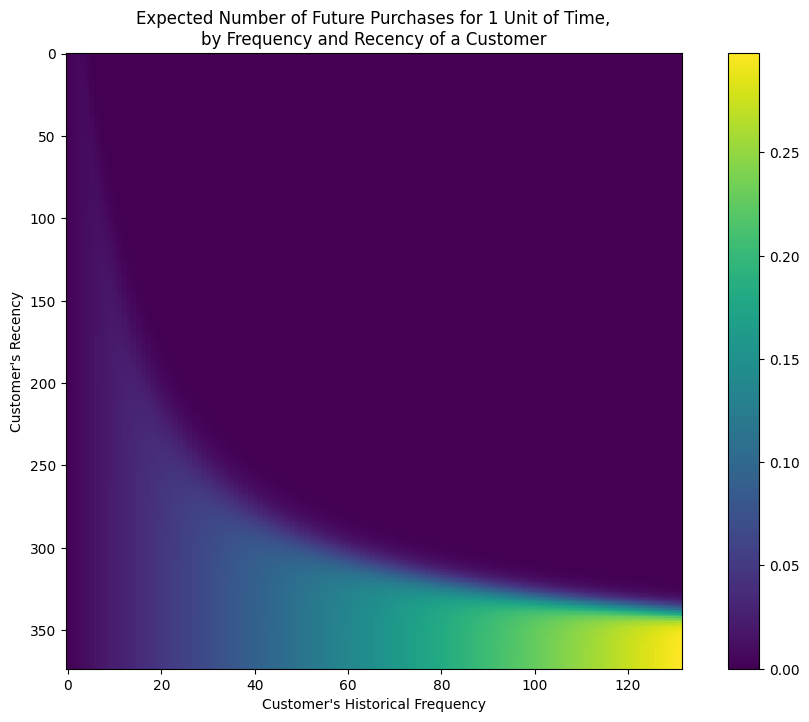

In [31]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

# Target: Predicting Purchases in the Next 1 Day

We aim to estimate the expected number of purchases a customer will make in the next 1 day, based on their historical transaction behavior.

**Visualization Axes:**
- X-axis: Frequency (how often the customer purchased)
- Y-axis: Recency (how recently the customer made a purchase)

**Insights:**
- Bottom-left to top-right (diagonal): Customers with balanced recency and frequency; generally reliable buyers.
- Top-right (dark area): High frequency but poor recency. These users haven't purchased in a while and may have churned.
- Bottom edge: Customers with good recency are more likely to make another purchase, even if their overall frequency is low.

**Conclusion:**  
Recency tends to be more predictive of future purchases than frequency. Customers who have purchased recently are more likely to return than those who were frequent buyers in the past but have not engaged recently.

# Churn/Active Probability

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

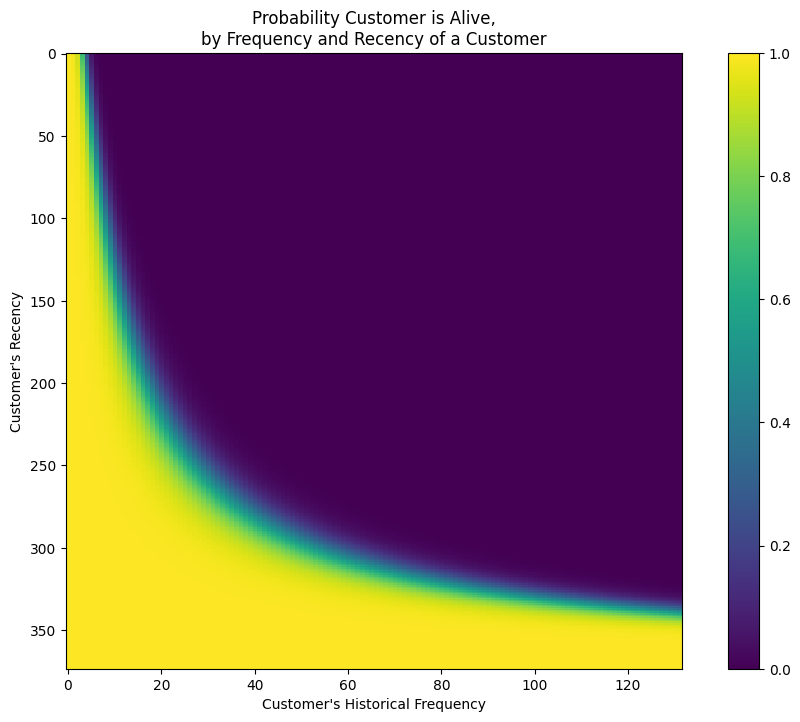

In [39]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

- Up-right: dead/silent
- Bottom-left: high activity. Active probability decrease exponentially with recency (time between first and last purchase) decrease.

# Predict Future Transaction Number

In [40]:
t = 1  # in the next 1 day
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])

In [41]:
# Highest 5 customers
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


In [42]:
# Lowest 5 customers
modeldata.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
18074.0,0.0,0.0,373.0,0.0,0.00187
16048.0,0.0,0.0,373.0,0.0,0.00187
16274.0,0.0,0.0,373.0,0.0,0.00187
14237.0,0.0,0.0,373.0,0.0,0.00187
14142.0,0.0,0.0,373.0,0.0,0.00187


# Model Validation: Period Transaction Plot

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

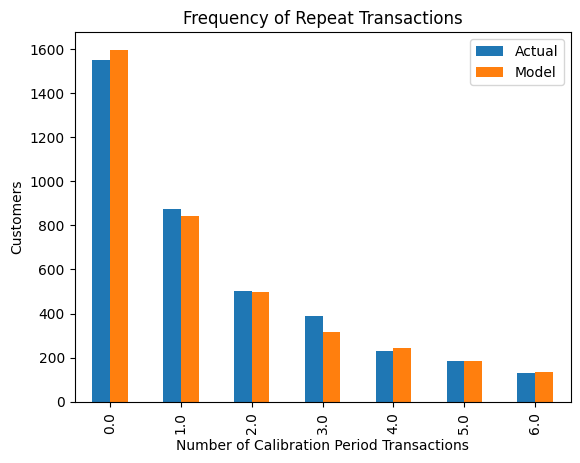

In [43]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

# Model Evaluation: Transaction Count vs Prediction Error

**X-axis:** Number of transactions during the calibration period (training window)  
**Y-axis (Gap/Error):** Difference between actual and predicted transaction counts

**Interpretation:**

- **Accuracy:**  
  The model is accurate if the gap between the actual and predicted values (two bars) is small.

- **Stability:**  
  The model is stable if both bars decline consistently across increasing transaction counts.  
  Inconsistent patterns indicate instability.

- **Error Behavior:**  
  - If the errors (gaps) fluctuate both positively and negatively, the model error is likely random, which is acceptable.
  - If the model consistently overpredicts or underpredicts, the error is not random, suggesting the model needs improvement.

**Conclusion:**  
A good model should be both accurate (small error) and stable (consistently declining pattern), with random error distribution.

# Model Validation: Split Calibration and Holdout Sets
Partition data into two parts. Fit the model on calibration (train) set, test on future/holdout.

In [44]:
summary_cal_holdout = calibration_and_holdout_data(dfnew, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-12-09' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,225.0,0.0,100.0
12347.0,4.0,238.0,267.0,2.0,100.0
12348.0,2.0,110.0,258.0,1.0,100.0
12350.0,0.0,0.0,210.0,0.0,100.0
12352.0,3.0,34.0,196.0,3.0,100.0


In [47]:
summary_cal_holdout[['frequency_cal', 'recency_cal', 'T_cal']].describe()
summary_cal_holdout.isnull().sum()

frequency_cal        0
recency_cal          0
T_cal                0
frequency_holdout    0
duration_holdout     0
dtype: int64

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

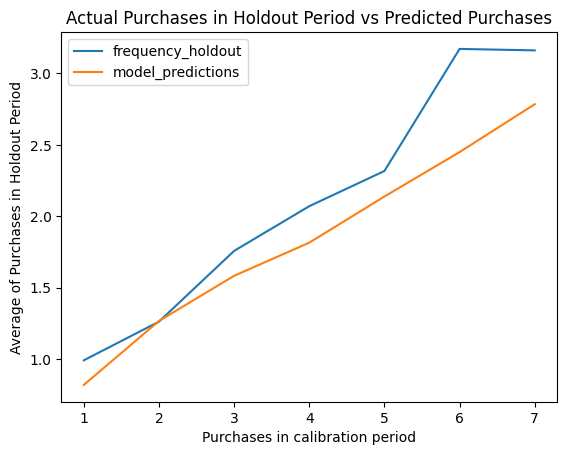

In [51]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

# Make sure to remove customers with frequency 0 (important for convergence)
summary_cal_holdout_clean = summary_cal_holdout[summary_cal_holdout['frequency_cal'] > 0]

# Fit BG/NBD model with slight penalization for stability
bgf2 = BetaGeoFitter(penalizer_coef=0.1)
bgf2.fit(
    summary_cal_holdout_clean['frequency_cal'],
    summary_cal_holdout_clean['recency_cal'],
    summary_cal_holdout_clean['T_cal']
)

# Plot actual vs predicted purchases in holdout period
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout_clean)

The model is good because model prediction (orange line) and true data (blue line) overlap.

In [52]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

In [53]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,
12347.0,4.0,238.0,267.0,2.0,100.0,1.557950
12348.0,2.0,110.0,258.0,1.0,100.0,0.934353
12352.0,3.0,34.0,196.0,3.0,100.0,1.381144
12356.0,1.0,80.0,225.0,1.0,100.0,0.550956
12359.0,2.0,142.0,231.0,1.0,100.0,1.041264
...,...,...,...,...,...,...
18257.0,4.0,182.0,196.0,2.0,100.0,2.002334
18260.0,5.0,186.0,258.0,0.0,100.0,1.916909
18263.0,1.0,97.0,152.0,1.0,100.0,0.862491


In [54]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [55]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  1.8891997154029778
SMAPE 0.9083748384617331
R2:  0.5982246120878261


In [56]:
# predict for a specific customer, number of purchase in next 10 days
t = 10
individual = modeldata.loc[12380]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

np.float64(0.15062434929966792)

# Gamma-Gamma Model: Predicting Average Monetary Value

The Gamma-Gamma model is used to **predict the average monetary value per transaction** for a customer in the future. It is especially useful when we know both the **historical transaction values** and the **pricing structure**.

#### Key Assumptions:
- Monetary value per transaction is independent of purchase frequency.
- Only applies to customers with at least **one repeat purchase**.

#### Why Focus on Repeat Customers?
Customers with **only one historical purchase** are unlikely to return, and thus unreliable for LTV forecasting. The model prioritizes customers who have already demonstrated repurchase behavior.

In [68]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

In [69]:
# 64% customer left
len(returning_customers_summary)/len(modeldata)

0.6430053007605439

In [70]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [71]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10)

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64

# Machine Learning: Xgboost and Lightgbm Algorithm
Features:

- customerID
- latetime: days between last transaction to now
- earlytime: days between first transaction to now
- freq: transaction frequency (whole history)
- freq_3m: transaction frequency (recent 3 months history)
- Target: number of transactions in test set

In [73]:
dfnew.InvoiceDate

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: InvoiceDate, Length: 397924, dtype: object

In [20]:
import datetime
import pandas as pd
import numpy as np
import datetime

dfnew = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')

dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate'])  # Convert to datetime

dfnew_train = dfnew[dfnew['InvoiceDate'] <= pd.Timestamp('2011-08-31')].copy()
dfnew_test = dfnew[dfnew['InvoiceDate'] > pd.Timestamp('2011-08-31')]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# getting time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# getting time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# getting transaction frequency (whole history)
dfsum3 = dfnew_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# getting transaction frequency (recent 3 months history)
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# getting target: number of transactions in test set
dfsum_target = dfnew_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [21]:
dfsum['target'].describe()

count    3355.000000
mean        1.917139
std         4.039643
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max       118.000000
Name: target, dtype: float64

In [22]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,target
1480,14911.0,0.279861,272.137500,130,56.0,118.0
254,12748.0,0.224306,272.190972,135,44.0,90.0
3099,17841.0,2.170139,272.120139,106,42.0,62.0
1307,14606.0,2.087500,272.018056,94,26.0,35.0
1712,15311.0,11.095139,272.320833,83,25.0,35.0
1331,14646.0,4.127083,253.301389,43,17.0,34.0
3248,18102.0,25.072222,266.028472,25,11.0,32.0
2882,17450.0,7.274306,266.333333,25,9.0,30.0
442,13089.0,5.127778,268.288889,86,23.0,28.0
620,13408.0,4.247222,272.280556,49,21.0,28.0


# XGB Model

In [13]:
import pandas as pd
import numpy as np

# Assuming dfnew is already cleaned and loaded
dfnew = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')

dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate'])  # Convert to datetime

dfnew_train = dfnew[dfnew['InvoiceDate'] <= pd.Timestamp('2011-08-31')].copy()
dfnew_test = dfnew[dfnew['InvoiceDate'] > pd.Timestamp('2011-08-31')]
dfnew_train['duration'] = (dfnew_train['InvoiceDate'].max() - dfnew_train['InvoiceDate']) / np.timedelta64(1, 'D')

dfsum1 = dfnew_train.groupby('CustomerID')['duration'].min().reset_index().rename(columns={'duration': 'latetime'})
dfsum2 = dfnew_train.groupby('CustomerID')['duration'].max().reset_index().rename(columns={'duration': 'earlytime'})
dfsum3 = dfnew_train.groupby('CustomerID')['InvoiceDate'].nunique().reset_index().rename(columns={'InvoiceDate': 'freq'})
dfsum4 = dfnew_train[dfnew_train['duration'] < 91].groupby('CustomerID')['InvoiceDate'].nunique().reset_index().rename(columns={'InvoiceDate': 'freq_3m'})

dfsum = dfsum1.merge(dfsum2, on='CustomerID', how='outer')
dfsum = dfsum.merge(dfsum3, on='CustomerID', how='outer')
dfsum = dfsum.merge(dfsum4, on='CustomerID', how='outer')

# Add target variable from test set
dfnew_test = dfnew[dfnew['InvoiceDate'] > pd.Timestamp('2011-08-31')]
dfsum_target = dfnew_test.groupby('CustomerID')['InvoiceDate'].nunique().reset_index().rename(columns={'InvoiceDate': 'target'})
dfsum = dfsum.merge(dfsum_target, on='CustomerID', how='left').fillna(0)

In [16]:
from sklearn.model_selection import train_test_split

predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum['target']

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum['target']

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:squarederror', max_depth=3, random_state=42)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_valid)
rmse = mean_squared_error(y_valid, y_pred) ** 0.5
print('✅ RMSE on test set:', rmse)

✅ RMSE on test set: 2.5512148486451083


In [21]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

# Define SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

# Fit XGBoost model
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:squarederror', max_depth=3)
xgb_model2.fit(X, y)

# Predict and evaluate
y_pred2 = xgb_model2.predict(X)
print('RMSE:', mean_squared_error(y, y_pred2) ** 0.5)
print('SMAPE:', smape(y, y_pred2))
print('R2:', r2_score(y, y_pred2))

RMSE: 0.8164156147541772
SMAPE: 100.71376027880478
R2: 0.9591430298156021


# Feature importance
importance_type:

- ‘weight’ - the number of times a feature is used to split the data across all trees.
- ‘gain’ - the average gain across all splits the feature is used in. most popular way.
- ‘cover’ - the average coverage across all splits the feature is used in. (yes/no proportion)
- ‘total_gain’ - the total gain across all splits the feature is used in.
- ‘total_cover’ - the total coverage across all splits the feature is used in.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

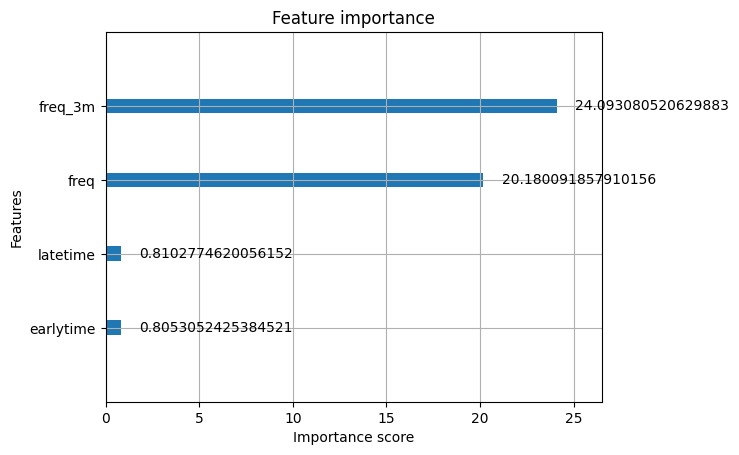

In [23]:
xgb.plot_importance(xgb_model, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

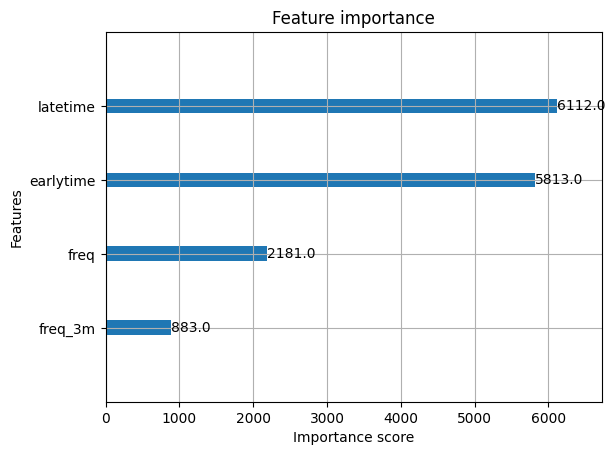

In [24]:
xgb.plot_importance(xgb_model, importance_type='weight')

# lgb Model

In [27]:
import lightgbm as lgb

lgbparams = {
    'n_estimators': 2200, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 3, 
    'learning_rate': 0.02
}

lgb_model = lgb.LGBMRegressor(**lgbparams)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_model.fit(x_trains, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 2348, number of used features: 4
[LightGBM] [Info] Start training from score 1.907155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.02
,n_estimators,2200
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [28]:
y_pred = lgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  2.3692281242576922


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

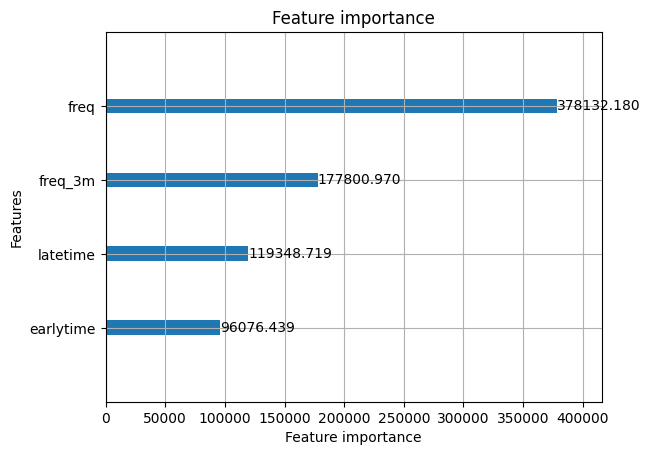

In [29]:
lgb.plot_importance(lgb_model, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

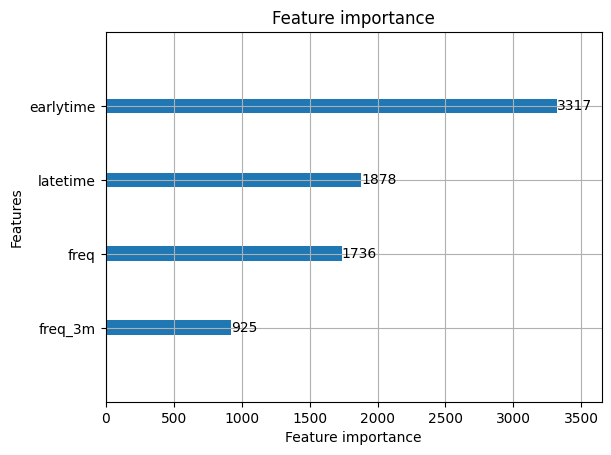

In [30]:
lgb.plot_importance(lgb_model) # defualt: weight

In [31]:
lgb_model2 = lgb.LGBMRegressor(**lgbparams)
lgb_model2.fit(X, y)
y_pred3 = lgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred3)**(1/2))
print('SMAPE', smape(y, y_pred3))
print('R2: ', r2_score(y, y_pred3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 3355, number of used features: 4
[LightGBM] [Info] Start training from score 1.917139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

# Model Comparison and Recommendations

### Probabilistic Modeling vs Machine Learning

#### BG/NBD Model  
- **RMSE**: 1.6298  
- **R²**: 0.5610  

#### XGBoost  
- **RMSE**: 0.9432  
- **R²**: 0.8530  

---

### Disadvantages of Probabilistic Models
1. **Limited Features**: Only transaction data used. Cannot incorporate variables like age, gender, education, behavior, or pricing.
2. **Assumption-Heavy**: Relies on strong assumptions about distributions. Real-world data may not follow these exactly.
3. **Accuracy Trade-off**: Due to these limitations, the model is generally less accurate than machine learning alternatives.

---

### Recommendations Based on Customer Segments

- **Champions**: Recent, frequent, high spenders.  
  → Reward with early product access, exclusive deals, and loyalty incentives.

- **Potential Loyalists**: Recent customers with decent frequency and monetary value.  
  → Engage with personalized offers and upgrade paths to loyal customer tiers.

- **Can’t Lose Them**: Once loyal, now inactive.  
  → Run win-back campaigns and feedback surveys to understand churn reasons.

- **New Customers**: Recent buyers with high spend but low frequency.  
  → Nurture through onboarding campaigns and incentives for repeat purchases.

---

### Customer Segmentation Overview

<div align="center">
    <img src="Image#5.png" alt="Customer Segments Treemap" width="75%">
</div>
